/home/olga/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6854 - loss: 0.8756 - val_accuracy: 0.8603 - val_loss: 0.4026
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.8596 - loss: 0.3864 - val_accuracy: 0.8755 - val_loss: 0.3476
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8801 - loss: 0.3295 - val_accuracy: 0.8804 - val_loss: 0.3295
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8927 - loss: 0.2941 - val_accuracy: 0.8956 - val_loss: 0.2868
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9015 - loss: 0.2670 - val_accuracy: 0.8967 - val_loss: 0.2853
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9141 - loss: 0.2354 - val_accuracy: 0.9028 - val_loss: 0.2731
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.9221 - loss: 0.2141 - val_accuracy: 0.9097 - val_loss: 0.2629
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9280 - loss: 0.1978 - 

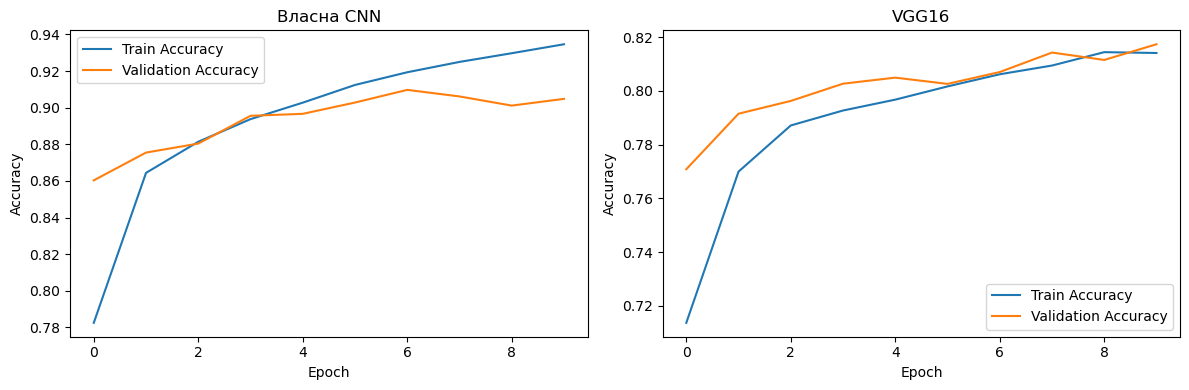

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

# Завантаження та підготовка даних
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Нормалізація даних
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Частина 1: Створення власної згорткової нейромережі

def create_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Створення та компіляція моделі
custom_model = create_custom_cnn()
custom_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Навчання моделі
custom_history = custom_model.fit(train_images, train_labels, epochs=10, 
                                  validation_split=0.2, batch_size=64)

# Оцінка моделі
custom_test_loss, custom_test_acc = custom_model.evaluate(test_images, test_labels, verbose=2)
print(f"\nТочність власної CNN на тестових даних: {custom_test_acc}")

# Частина 2: Використання VGG16 як згорткової основи

def create_vgg16_model():
    # Завантаження VGG16 без верхніх шарів
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # Заморожування шарів VGG16
    for layer in base_model.layers:
        layer.trainable = False
    
    # Додавання нових шарів
    model = models.Sequential([
        layers.UpSampling2D(size=(2, 2)),  # Збільшення розміру з 28x28 до 56x56
        layers.Cropping2D(cropping=((12, 12), (12, 12))),  # Обрізка до 32x32
        layers.Conv2D(3, (1, 1), padding='same', activation='relu'),  # Конвертація в 3 канали
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Створення та компіляція моделі VGG16
vgg16_model = create_vgg16_model()
vgg16_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Підготовка даних для VGG16
train_images_rgb = np.repeat(train_images, 3, axis=-1)
test_images_rgb = np.repeat(test_images, 3, axis=-1)

# Навчання моделі VGG16
vgg16_history = vgg16_model.fit(train_images_rgb, train_labels, epochs=10, 
                                validation_split=0.2, batch_size=64)

# Оцінка моделі VGG16
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_images_rgb, test_labels, verbose=2)
print(f"\nТочність моделі VGG16 на тестових даних: {vgg16_test_acc}")

# Візуалізація результатів
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(custom_history.history['accuracy'], label='Train Accuracy')
plt.plot(custom_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Власна CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()